# 第五週: 中文文集的情緒分析2

**Author:** 蔡睿澤<br>
**Date created:** 2024/03/10<br>
**Last modified:** 2024/03/10<br><br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用中研院提供的CKIP自然語言處理工具包，但其中不像coreNLP有提供情緒分析套件，所以在此介紹一款用於中文情緒分析的套件SnowNLP，是Courpus-base的情緒分析，不是使用情緒字典，而是使用預訓練的情緒分析模型或演算法，給與整個文章一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹CKIP、分析方法、SnowNLP

## 大綱
1. 套件說明
2. CKIP 介紹
    + 2.1 安裝CKIP
    + 2.2 利用CKIP進行自然語言處理
3. CKIP 標註
    + 3.1 將抓取結果用CKIP進行處理
    + 3.2 探索分析 - NER
    + 3.3 探索分析 - POS
4. 利用SnowNLP進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [152]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [153]:
# 確認當前工作目錄
# %pwd

In [154]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import res
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import time
import re
import datetime


如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [155]:
# data_utils.download_data_gdown("./")  # 下載ckip model

### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [156]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/opt/homebrew/anaconda3/envs/SMA/lib/python3.9/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


/opt/homebrew/anaconda3/envs/SMA/lib/python3.9/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/homebrew/anaconda3/envs/SMA/lib/python3.9/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [157]:
# 自定義辭典
word_to_weight = {
    "魔法覺醒": 100,
    "睽違已久": 100,
}
dictionary1 = construct_dictionary(word_to_weight)
print(dictionary1)

[(4, {'魔法覺醒': 100.0, '睽違已久': 100.0})]


In [158]:
sentence_list = [
    "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
    "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
]

word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞，可以嘗試不放斷詞字典，看看結果會有什麼不同
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(sentence_list):
    print()
    print("="*30)
    print(f"sentence {i}: {sentence}")
    print("\nPOS: ")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    print("\nNER: ")
    for entity in sorted(entity_sentence_list[i]):
        print(entity)
    


sentence 0: 哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app

POS: 
哈利波特(Nb)　魔法覺醒(Nb)　是(SHI)　一(Neu)　個(Nf)　中國(Nc)　網易(Nb)　代理(VC)　的(DE)　粉絲(Na)　睽違已久(VH)　的(DE)　手遊(Na)　app(FW)　

NER: 
(11, 13, 'NORP', '中國')
(13, 15, 'ORG', '網易')

sentence 1: 很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害

POS: 
很多(Neqa)　人(Na)　滿心(D)　期待(VK)　這(Nep)　款(Nf)　英國(Nc)　出品(VC)　的(DE)　遊戲(Na)　，(COMMACATEGORY)　卻(D)　又(D)　害怕(VK)　受(VJ)　傷害(Na)　

NER: 
(9, 11, 'GPE', '英國')


## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」(1630筆)
+ 時間: 2020-01-10 ~ 2022-12-31

我們已經介紹過CKIP的使用方式，現在來對PTT的資料使用CKIP進行自然語言處理

In [159]:
## 讀取文章
df = pd.read_csv('./data/raw_data.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,ATF91,Stock,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""hebeisme5566...",42.77.223.199,2023-03-21 02:21:44,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20 13:23:04,black1x2y3z,Stock,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\n原文連結：\nhttps://t...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""maxdi"", ""cmt...",140.121.145.184,2023-03-21 02:21:44,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20 14:05:26,Timzy,Stock,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxcv91039"", ...",223.141.185.139,2023-03-21 02:21:49,ptt


In [160]:
# 秉祐 : 清理artContent有nan的值
df.dropna(subset=['artContent'], inplace=True)

定義文字清理的相關function

In [161]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP 處理相關function

In [162]:
# 自定義辭典
with open('dict/user_dict_ckip.txt') as f:
    lines = f.read().splitlines()
print(lines)
dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

['面額 500', '面值 500', '市價 500', '丙種 500', '淨值 500', '毛利率 500', '最高價 500', '最低價 500', '成交價 500', '成交值 500', '成交量 500', '漲跌停板 500', '除息 500', '除權 500', '填息 500', '填權 500', '技術面 500', '基本面 500', '基本盤 500', '題材面 500', '籌碼面 500', '技術分析 500', '毛利 500', '被動投資 500', '主動投資 500', '基金 500', '指數型基金 500', 'ETF 500', '期貨 500', '債券 500', '證券 500', '選擇權 500', '創投 500', '私募基金 500', '避險基金 500', '共同基金 500', '股票型基金 500', '科技股 500', '股票市場 500', '總體經濟 500', '景氣循環 500', '價值投資 500', '經濟利潤 500', '散戶 500', '機構投資人 500', '金融市場 500', '投資組合 500', '基本面 500', '基本面分析 500', '風險趨避 500', '商品可轉讓 500', '同質產品 500', '基金經理人 500', 'IPO 500', '上市公司 500', '資金成本 500', '折現率 500', '現金流量 500', '自由市場 500', '次級市場 500', '初級市場 500', '完全競爭市場 500', '異質市場 500', '流動性 500', '錯價 500', '股利 500', '要求報酬率 500', '殖利率 500', '經理費／管理費 500', '保管費 500', '聯邦準備理事會 500', '資本資產定價模型 500', '資本市場 500', '盈餘慣性 500', '基點 500', '財務報表 500', '投資組合權數 500', '隱含報酬率 500', '存股（票） 500', '分散風險 500', '融資 500', '融券（墊股） 500', '解套 500', '買超 500', '賣超 500', '利率 500', '股票價格 500'

In [163]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        # 發現artContent有na值，處理方式，轉成空字串
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [164]:
for index, value in enumerate(df['artContent']):
    tmp=Sentence_Segmentation(value) 
    if(index==1663):
        print(tmp)

[['標題外資買賣超排行'], ['來源台灣證交所'], ['網址'], ['////'], ['內文'], ['買超'], ['華通,'], ['玉山金,'], ['中信金,'], ['金像電,'], ['中工,'], ['中興電,'], ['神達,'], ['中磊,'], ['健鼎,'], ['華泰,'], ['永豐金,'], ['正新,'], ['中鼎,'], ['亞太電,'], ['精元,'], ['第金,'], ['國泰美國道瓊正,'], ['合庫金,'], ['群創,'], ['聯成,'], ['遠東新,'], ['大聯大,'], ['虹堡,'], ['兆豐金,'], ['台積電,'], ['新日興,'], ['華南金,'], ['臺企銀,'], ['聯茂,'], ['和碩,'], ['力山,'], ['可成,'], ['富邦越南,'], ['國泰費城半導體,'], ['微星,'], ['亞泥'], ['致茂'], ['新唐'], ['愛普'], ['聯詠'], ['三芳'], ['台達電'], ['瑞鼎'], ['達方'], ['敬鵬'], ['台光電'], ['勤誠'], ['定穎投控'], ['云辰'], ['群光'], ['賣超'], ['宏碁,'], ['詮,'], ['佳世達,'], ['開發金,'], ['國泰永續高股息,'], ['裕隆,'], ['誠美材,'], ['中租,'], ['友達,'], ['復華台灣科技優息,'], ['南亞科,'], ['中信中國高股息,'], ['台新永續高息中小,'], ['裕民,'], ['漢翔,'], ['同欣電,'], ['合勤控,'], ['復華富時不動產,'], ['基泰,'], ['群益台灣精選高息,'], ['力積電,'], ['工信,'], ['三商壽,'], ['良得電,'], ['智原,'], ['台泥,'], ['元大高股息,'], ['中華電,'], ['華邦電,'], ['十銓,'], ['京元電子,'], ['東元,'], ['輔信,'], ['景碩,'], ['大同,'], ['世紀鋼,'], ['富邦基因免疫生技,'], ['希望不要有人問我怎麼沒有合跟中天_'], ['顏色等等補']]


In [165]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['標的富時不動產'], ['例台積電'], ['分類討論'], ['分析/正文'], ['這隻已經超過周都大溢價~趴，股價卻沒有急速下跌，是每天凌遲你那種小小跌，明']]
['標的富時不動產', '例台積電', '分類討論', '分析/正文', '這隻已經超過周都大溢價~趴，股價卻沒有急速下跌，是每天凌遲你那種小小跌，明']


In [166]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 609.4660110473633


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [167]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,標的,Na
1,1,富時,Na
2,1,不動產,Na
3,1,例,Na
4,1,台積電,Nb


In [168]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,台積電,ORG
1,1,整年,DATE
2,2,金控,ORG
3,2,日週上午,TIME
4,2,葉憶如,PERSON


In [169]:
sentence_table.head()

,system_id,sentence
0,1,標的富時不動產
1,1,例台積電
2,1,分類討論
3,1,分析/正文
4,1,這隻已經超過周都大溢價~趴，股價卻沒有急速下跌，是每天凌遲你那種小小跌，明


In [170]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 2771篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 2767篇有抓到ner

total posts numbers: 2771
posts have NER: 2767


In [171]:
# 將文章存成csv
pos_table.to_csv('data/pos_table_buffet.csv', index = False)
entity_table.to_csv('data/entity_table_buffet.csv', index = False)
sentence_table.to_csv('data/sentence_table_buffet.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [172]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("data/pos_table_buffet.csv") 
entity_table = pd.read_csv("data/entity_table_buffet.csv") 
sentence_table = pd.read_csv("data/sentence_table_buffet.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [173]:
entity_table['ner'].unique()

array(['ORG', 'DATE', 'TIME', 'PERSON', 'CARDINAL', 'NORP', 'GPE',
       'ORDINAL', 'PRODUCT', 'LOC', 'MONEY', 'FAC', 'PERCENT',
       'WORK_OF_ART', 'LAW', 'EVENT', 'QUANTITY', 'LANGUAGE'],
      dtype=object)

ORG：涉及到的組織，如公司、政府組織等。  
DATE：日期。  
TIME：時間。  
PERSON：人名。  
CARDINAL：基數，例如數字、計數等。  
NORP：國家、宗教或政治團體。  
GPE：地理政治實體，如國家、城市等。  
ORDINAL：序數，如 "第一"、"第二" 等。  
PRODUCT：產品，如軟件、汽車等。  
LOC：位置，通常是具體的地理位置。  
MONEY：金錢。  
FAC：建築物、機構等。  
PERCENT：百分比。  
WORK_OF_ART：藝術作品，如書籍、畫作等。  
LAW：法律文件、法律條款等。  
EVENT：事件，如戰爭、節日等。  
QUANTITY：量詞，如 "2公斤"、"3米" 等。  
LANGUAGE：語言。  

In [174]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
11,ORG,44870
4,GPE,11537
13,PERSON,10210
1,DATE,9610
0,CARDINAL,4131
8,MONEY,2533
10,ORDINAL,1500
9,NORP,1164
7,LOC,968
16,TIME,338


/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/625636172.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


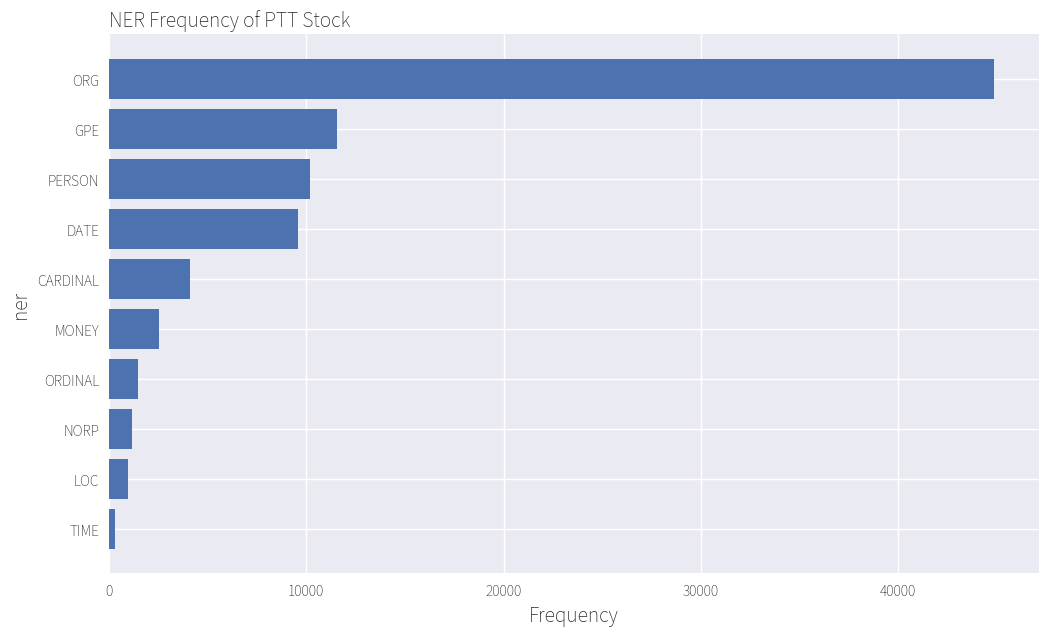

In [175]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Stock',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的組織(ORG)  

In [202]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/178926110.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


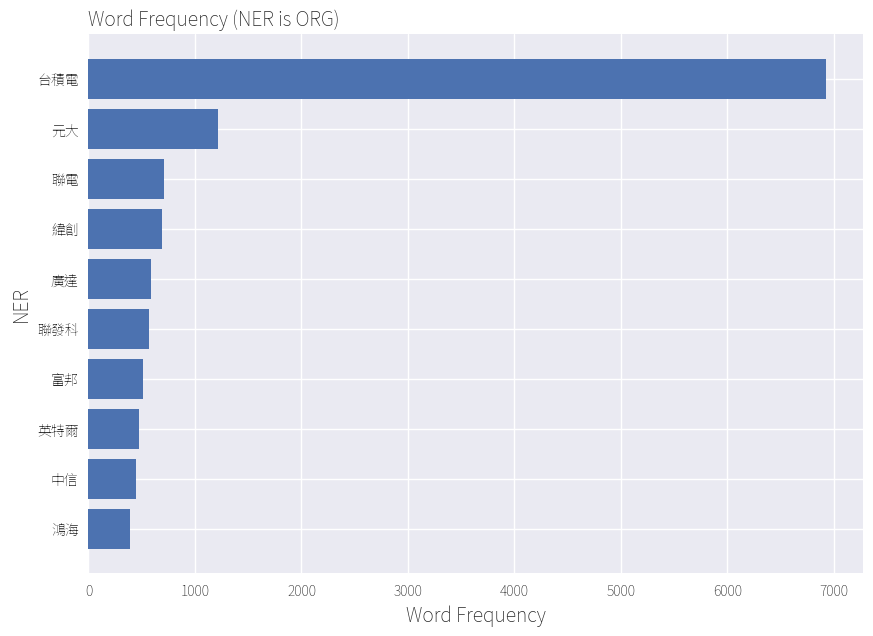

In [177]:
# 篩選ner為NORP的資料
l_noun = ["ORG"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到台灣人喜好的口味大多以「日式」、「韓式」料理為大宗

### 地理政治實體(GPE)

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/4011506578.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


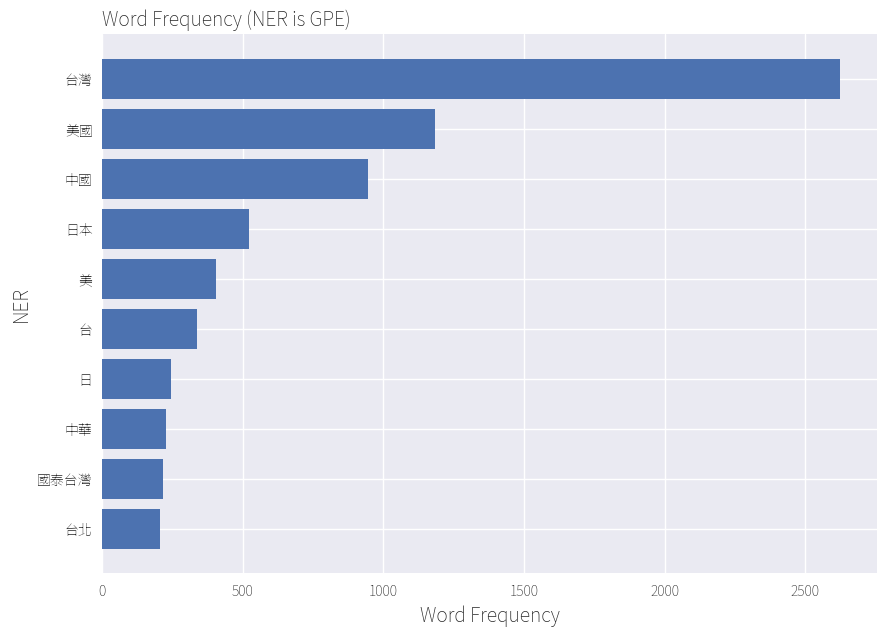

In [178]:
# 篩選ner為ORG的資料
l_noun = ["GPE"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is GPE)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到在多數的吃到飽食記之中，「哈根達斯」是多數食記會介紹到的一環，也間接反映出讀者對於吃到飽餐廳冰淇淋品牌的關注。

### 涉及到的人名(PERSON)

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/1529189926.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


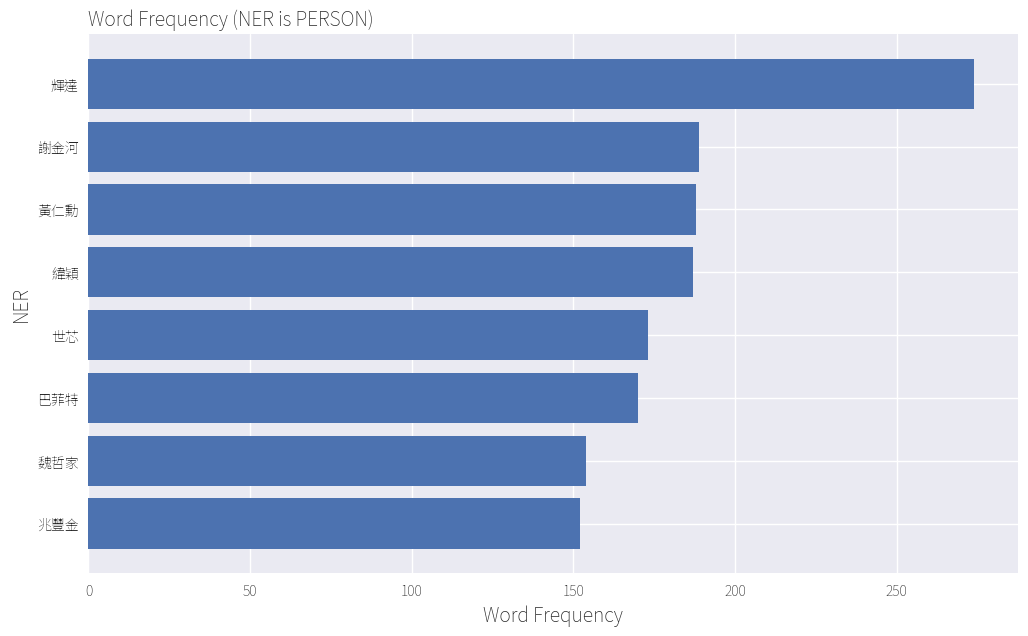

In [179]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

下面找出「台積電」相關文章，與後續情緒分析一起做探索

In [180]:
keyword_list = ['台積電']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

台積電：2687篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,ATF91,Stock,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""hebeisme5566...",42.77.223.199,2023-03-21 02:21:44,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20 13:23:04,black1x2y3z,Stock,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\n原文連結：\nhttps://t...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""maxdi"", ""cmt...",140.121.145.184,2023-03-21 02:21:44,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20 14:05:26,Timzy,Stock,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxcv91039"", ...",223.141.185.139,2023-03-21 02:21:49,ptt


### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [181]:
pos_table['pos'].unique()

array(['Na', 'Nb', 'VE', 'VC', 'FW', 'Nep', 'Nf', 'D', 'VJ', 'Nd', 'VH',
       'VA', 'COMMACATEGORY', 'SHI', 'Nes', 'Nh', 'Neqa', 'V_2', 'Ng',
       'Di', 'P', 'Dk', 'T', 'Ncd', 'DE', 'VCL', 'Dfb', 'Cbb', 'VK', 'Nc',
       'VF', 'Cab', 'Neu', 'VHC', 'Da', 'Dfa', 'Nv', 'DM', 'A', 'VB',
       'VG', 'Caa', 'VD', 'VL', 'I', 'VAC', 'VI', 'PARENTHESISCATEGORY',
       'Neqb', 'Cba', 'COLONCATEGORY', 'PERIODCATEGORY', 'DOTCATEGORY',
       'ETCCATEGORY', 'PAUSECATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [182]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
17,Na,164177
18,Nb,59825
5,D,51712
38,VC,48235
44,VH,41430
19,Nc,34585
31,P,23112
6,DE,19763
21,Nd,16578
27,Nf,14912


#### POS 常見詞性列表
+ Na: 普通名詞
+ D: 副詞
+ VC: 動作及物動詞
+ Nb: 專有名詞
+ FW: 外文
+ VH: 狀態不及物動詞
+ Nh: 代名詞
+ DE: 的之得地
+ P: 介詞
+ VA: 動作不及物動詞
+ T: 語助詞
+ SHI: 是

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/2464247814.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


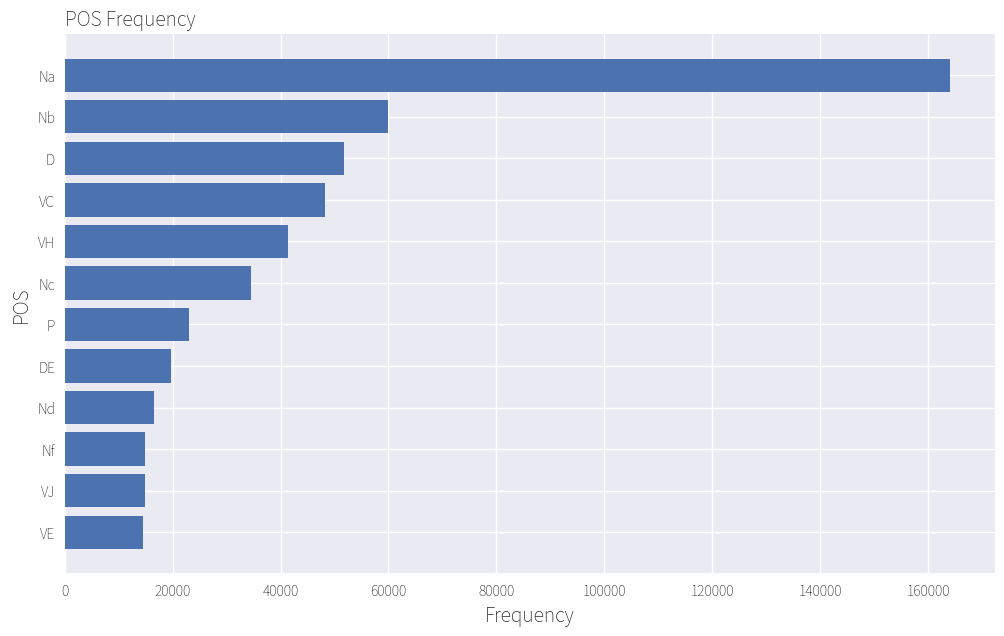

In [183]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('POS Frequency',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論吃到飽時大部分討論到的名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [203]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]
noun = noun[noun['word'].map(len) > 1] 
# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

noun_count.head(10)

,word,count
540,台積電,7909
254,元大,1655
745,國泰,1540
3394,長榮,846
2676,聯電,808
2553,緯創,788
1008,富邦,768
2666,聯發科,665
3142,輝達,657
1180,廣達,655


/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/4129530073.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


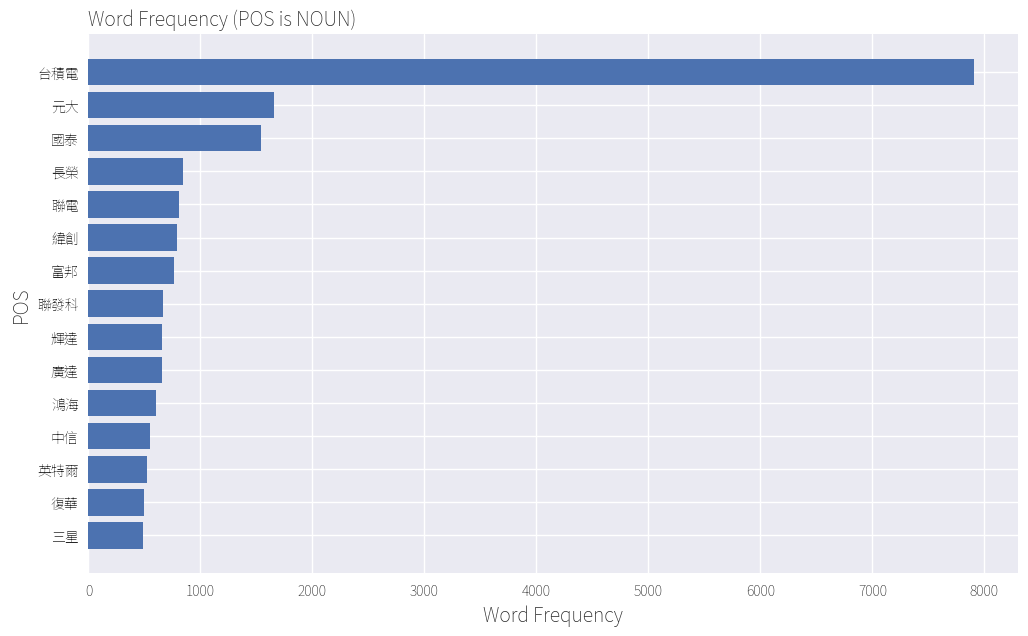

In [204]:
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [213]:
# 篩選pos為專有名詞的資料
l_noun = ["Na"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]
noun = noun[noun['word'].map(len) > 1] 
stopwords = ['原文', '標題', '內容', '時間', '心得','來源','評論']
noun = noun[~noun['word'].isin(stopwords)]
# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
1520,半導體,1796
4850,晶片,1774
1753,台股,1712
2419,外資,1391
7753,股息,1337
8459,記者,1285
6109,營收,1230
2690,奈米,1226
7720,股價,1187
7799,股票,1187


/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/4129530073.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


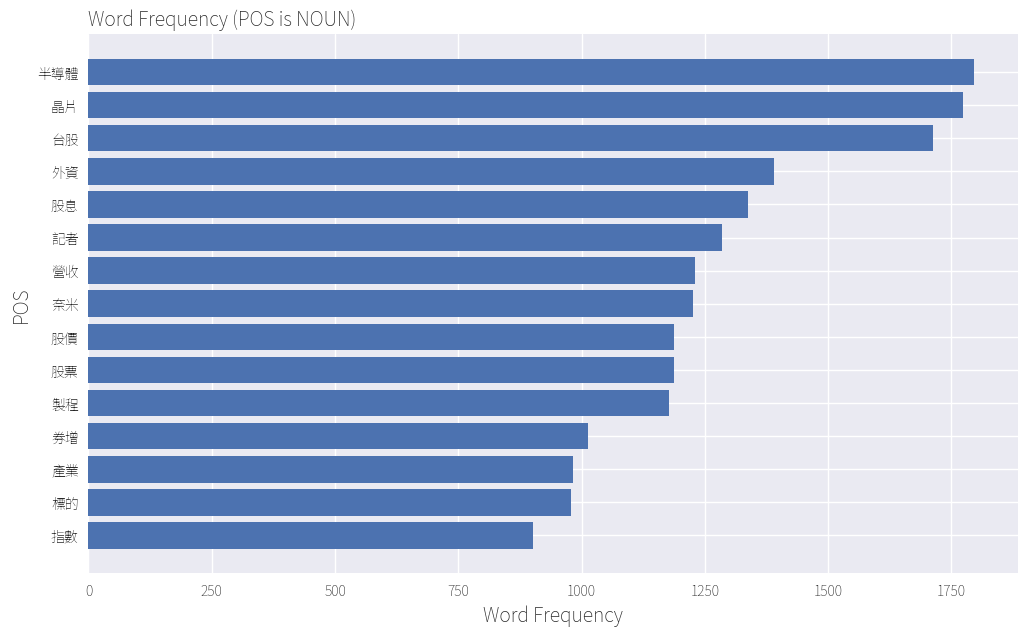

In [214]:
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到哈根達斯依舊是出現最多次的專有名詞，另外，從「安格斯」、「菲力」和「松阪」等專有名詞可以推測出大家對於肉類也有較高的討論度。

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [186]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
1141,投資,1431
2104,發布,1047
2981,連結,991
2414,署名,912
276,分析,601
2102,發展,434
2539,表現,427
2783,買進,413
102,使用,398
2571,製造,390


/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_19607/3629697705.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


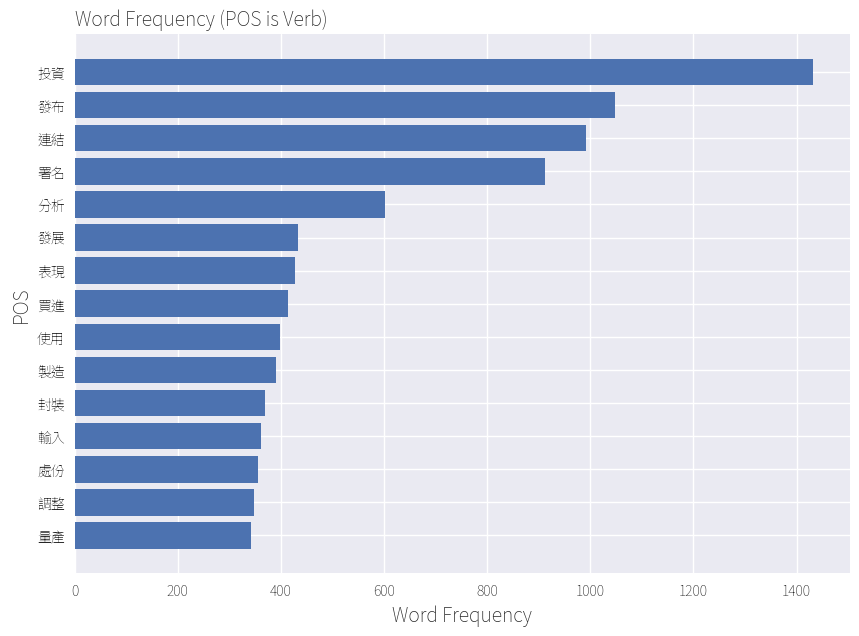

In [187]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Verb)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「吃到」佔了相當高的頻率，其他還有出現「選擇」、「搭配」等詞彙，可推測民眾對於食材的選擇多樣性有較高的重視程度。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [188]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

使用先前NER得到的「旭集」相關文章，看看旭集相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [189]:
sentence_table = pd.read_csv("data/sentence_table_buffet.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
0,1,標的富時不動產,2023-03-20 10:32:54,ptt
1,1,例台積電,2023-03-20 10:32:54,ptt
2,1,分類討論,2023-03-20 10:32:54,ptt


In [190]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,標的富時不動產,2023-03-20 10:32:54,ptt,0.112694
1,1,例台積電,2023-03-20 10:32:54,ptt,0.563908
2,1,分類討論,2023-03-20 10:32:54,ptt,0.213409


In [191]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.159130e+05
mean     4.443745e-01
std      2.903989e-01
min      2.220446e-15
25%      1.930021e-01
50%      4.737672e-01
75%      6.585312e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

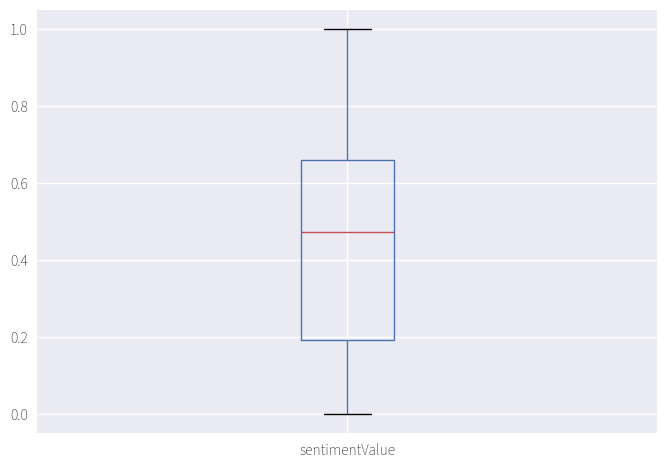

In [192]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [193]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2023-03,0.457926
1,2023-04,0.433860
2,2023-05,0.461573
3,2023-06,0.446623
4,2023-07,0.434863
5,2023-08,0.418254
6,2023-09,0.417026
7,2023-10,0.449004
8,2023-11,0.476000
9,2023-12,0.466924


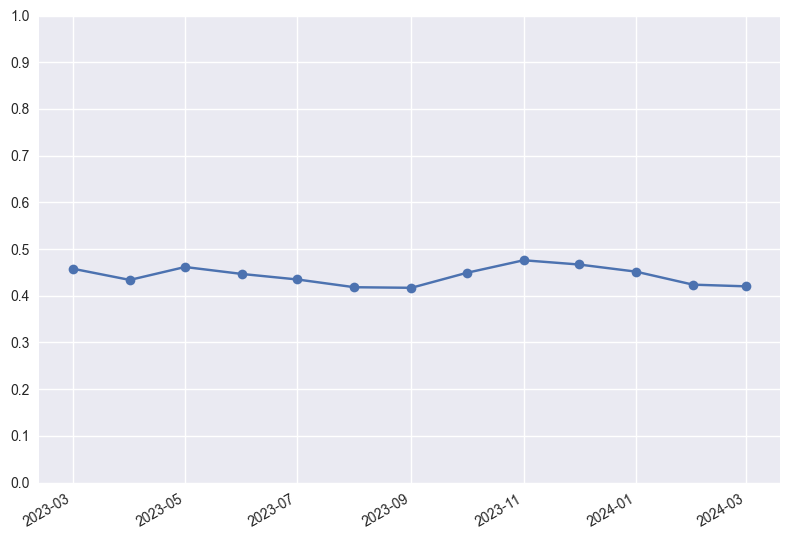

In [194]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
# 設定 y 軸刻度
plt.yticks([i/10 for i in range(11)])  # 將 y 軸刻度設定為 0 到 1，每隔 0.1 一個間隔
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性，推測是因為PTT美食板上多數為食記類型的介紹文章。我們挑出 2022年11月 來分析。

### 詞彙探索
從上圖中可以發現 2022年11月 的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [195]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2023-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.48]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
68561,1605,////,2023-11,ptt,0.500000
68563,1605,記者署名陳瑩欣,2023-11,ptt,0.654304
68568,1605,元，買超以台積電聯發科最多，其中,2023-11,ptt,0.744870
68570,1605,金額高達億元，聯發科護盤金額則逼近億元,2023-11,ptt,0.901938
68575,1605,"多蛙不用擔心,有黑手好安心",2023-11,ptt,0.644662


In [196]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,1605,0.5,原文
1,1605,0.5,標題
2,1605,0.5,愈
3,1605,0.5,跌
4,1605,0.5,愈


In [197]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [198]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()
print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

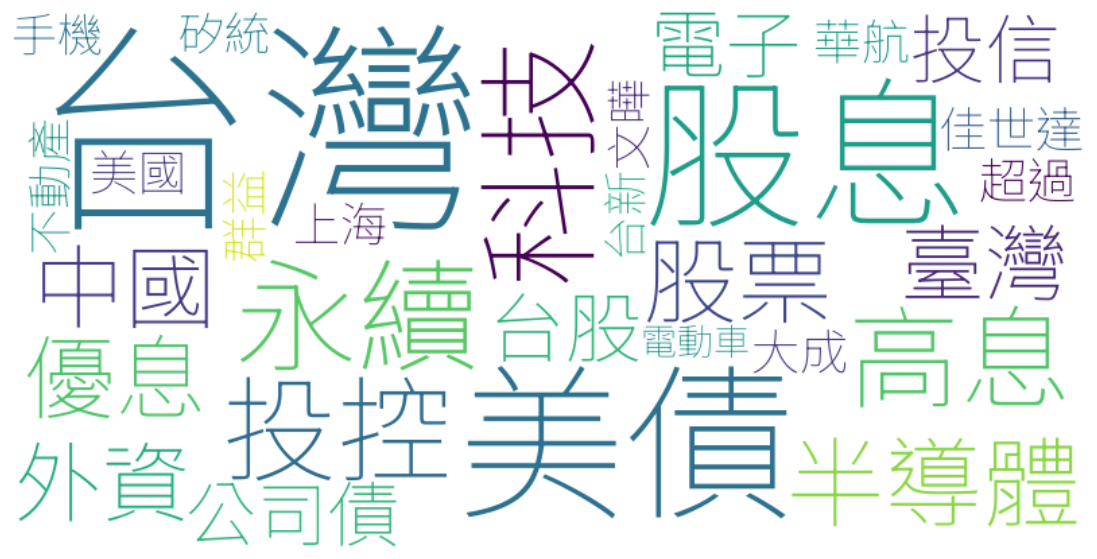

In [226]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('富時','不動產富時','商銀','永豐','京元','華泰','宏碁','華通','中信','彰銀','威盛','日月光','遠東','證交所','第金','兆豐','復華','仁寶','華邦','金額','排行','漲跌','張數','網址','買超','賣超','來源','排名','內文','先進','投資人','展望','成長','競爭','需求','領域','市值','進入','企業','漲幅','賺錢','看好','世界','預期','持續','現在','政府','應用','本業','理由','維持','市場','美元','國家','變化','副業','策略','領先','優勢','帶動','重要','原文','公司','目前','認為','成為','表示','第二','署名','標題','相關','心得','今年','時間','連結','指出','包括','評論','內容','發布','風險','去年','記者','表現','未來','子公司','指數','股市','經濟'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'font/TraditionalChinese.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=30, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

藉由各式海鮮以及「日式」、「手捲」、「壽司」等詞彙出現在正向文章中，可以知道多數文章對旭集的日本料理類有正面的評價，另外，甜點類也是多數文章會提及的詞彙